In [15]:
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.optimize import curve_fit
import scipy

In [2]:
# Physics Functions
def V(R):
    """Woode-Saxon potential"""
    V0 = -61.1 #MeV
    A = 10 #mass of the core
    Rws = 1.2*A**(1/3) #fm
    aws = 0.65 #fm
    return V0/(1+np.exp((R-Rws)/aws))


def breit_wigner(L: int, delta: float,E: float):   
    c2 = 0.0478450
    k2 = c2*E #k^2
    return (4*np.pi*(2*L+1)*(np.sin(delta))**2)/k2 #fm2


#Numerical Method functions
def f(R,y,L,E):
    """Matrix solutions to RKmethod f(R,y)=(u(1),u(0)* [RHS equation 3.126])"""
    c1 = 197.32075 #MeV fm -> hc
    c2 = 0.0478450 #1/(MeV fm2) -> 2u/hbar2
    return np.array([[y[1,0]],[y[0,0]*(L*(L+1)/R**2 + c2*(V(R)-E))]])

def RKmethod(Rn=np.array([]),yn=np.array([[0],[1]]),Lval=0,Eval=0):
    """Runge-Kutta Method: It is initialized for u(0)=0 and u'(0)=1.
    The parameter "a" will help us identify the index for which r==a in the index notation."""
    u  = []
    up = [] #u'
    step_size = r_array[1]-r_array[0]
    for idx, Rn in enumerate(r_array):
        #define the parameters
        k1 = f(R=Rn,y=yn,L=Lval,E=Eval)
        k2 = f(R=Rn+0.5*step_size,y=yn+0.5*step_size*k1,L=Lval,E=Eval)
        k3 = f(R=Rn+0.5*step_size,y=yn+0.5*step_size*k2,L=Lval,E=Eval)
        k4 = f(R=Rn+step_size,y=yn+step_size*k3,L=Lval,E=Eval)
        #Redefine new functions
        yn = yn + (step_size/6)*(k1+2*k2+2*k3+k4)
        Rn = Rn + step_size
        u.append(yn[0,0])
        up.append(yn[1,0])
    return u,up #u(r)

def normalize(array_to_normalize):
    """ It normalizes an array from its maximum amplitude and will oscillate from [-1,1]"""
    normalized_array = array_to_normalize/max(array_to_normalize)
    return normalized_array

#Fitting functions

def gaussian(x, amplitude, mean, stddev):
    return amplitude * np.exp(-((x - mean) ** 2) / (2 * stddev ** 2))




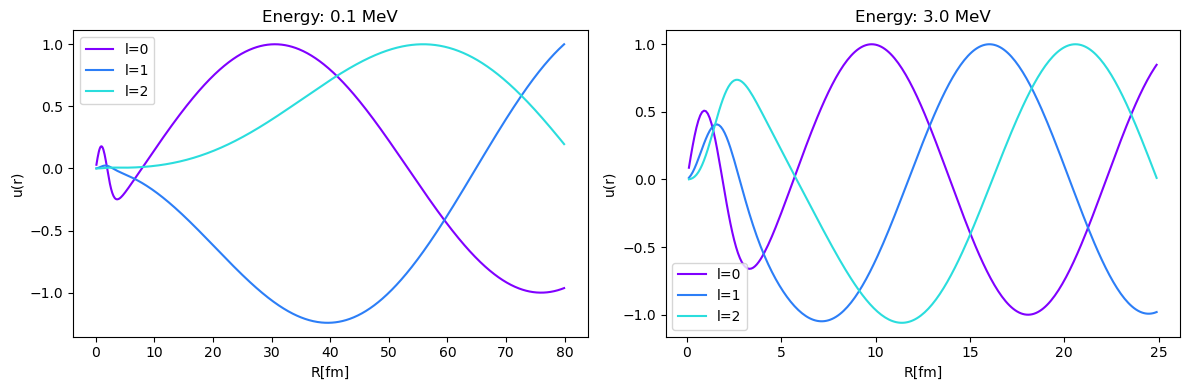

In [3]:
#Initial conditions
step_size = 0.1


a=10 #potential is zero ish

##Plot figures
fig, axs = plt.subplots(1,2,figsize=(12.0,4.0))
numbers_of_l = 3
energies = [0.1,3.0]
for idx,energy in enumerate(energies):
    color = iter(cm.rainbow(np.linspace(0,0.5,numbers_of_l+1)))
    c = next(color)
    
    #Define range of R limits
    if idx ==0: r_array = np.arange(0.1,80,step_size)
    else: r_array = np.arange(0.1,25,step_size)

    if idx ==0: axs[idx].set_title(f'Energy: {energy} MeV')
    else: axs[idx].set_title(f'Energy: {energy} MeV')

    for l in range(0,numbers_of_l):
        y,yp= RKmethod(Rn=r_array,Lval=l,Eval=energy)
        y_norm = normalize(y)
        axs[idx].plot(r_array, y_norm,label=f"l={l}",color=c)
        axs[idx].set_xlabel("R[fm]")
        axs[idx].set_ylabel("u(r)")
        axs[idx].legend()
        c = next(color)

fig.tight_layout()
fig.savefig('radial_behaviour.png')

/tmp/ipykernel_239/1272292633.py:8: RuntimeWarning: overflow encountered in exp
  return V0/(1+np.exp((R-Rws)/aws))


9.6677982762668


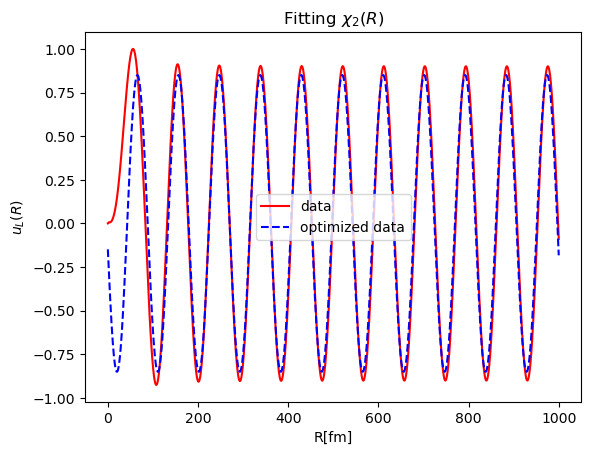

In [21]:
#Fit the Phase shift 
c2 = 0.0478450
energy = 0.1
k = np.sqrt(c2*energy)
L=2

r_array = np.arange(0.1,1000,step_size)
y,yp = RKmethod(Rn=r_array,Lval=L,Eval=energy)
y = normalize(y)


def function(R: float, A:float, B:float):
    """Fit the delta function"""
    return A*np.sin(k*R+ B - L*np.pi/2)

param, param_cov = curve_fit(function,r_array,y)
ans = (param[0]*(np.sin(k*r_array + param[1] - L*np.pi/2)))


print(np.rad2deg(param[1]))
plt.plot(r_array, y, color ='red', label ="data")
plt.plot(r_array, ans, '--', color ='blue', label ="optimized data")
plt.title(r'Fitting $\chi_2(R)$')
plt.xlabel('R[fm]')
plt.ylabel(r'$u_{L}(R)$')
plt.legend()
plt.savefig('fitx.png')
plt.show()


C:\Users\ramirezc\AppData\Local\Temp\ipykernel_6740\1272292633.py:8: RuntimeWarning: overflow encountered in exp
  return V0/(1+np.exp((R-Rws)/aws))


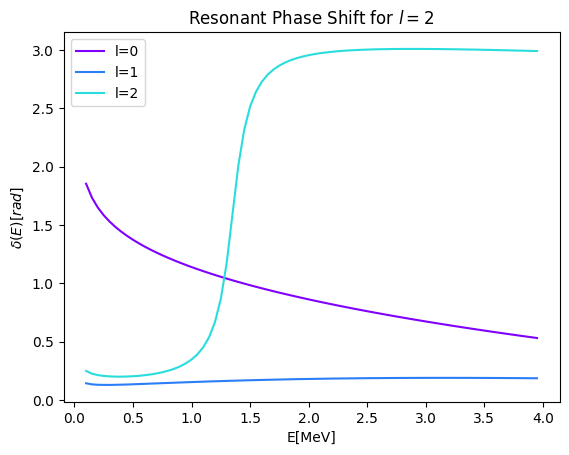

In [43]:
step_size = 0.5
energy_range = np.arange(0.1,4.0,0.05)
r_array = np.arange(0.3,700,step_size)


#Initial parameters
numbers_of_l = 3
#if we select the R=a for which V~0 for the nuclear range
a = 100
color = iter(cm.rainbow(np.linspace(0,0.5,numbers_of_l+1)))
c = next(color)
for l in range(3):
    phase_shift = []
    for energy in energy_range:
        k = np.sqrt(0.0478450*energy)
        y_l0, yp_l0 = RKmethod(Rn=a,Lval=l,Eval=energy)
        y_l0_norm = normalize(y_l0)
        def function(R: float, A:float, B:float):
            """Fit the delta function"""
            return A*np.sin(k*R+ B - l*np.pi/2)
        #fit the sinudal expression for the Ul vs r plot.
        param, param_cov = curve_fit(function,r_array,y_l0_norm)
        phase_shift.append(param[1])

    plt.plot(energy_range,(phase_shift),label=f'l={l}',c=c)
    c = next(color)

plt.title(r"Resonant Phase Shift for $l=2$")
plt.ylabel(r'$\delta(E) [rad]$')
plt.xlabel(r'E[MeV]')
plt.legend()
plt.savefig(f'phase_e_a{a}.png')
plt.show()

standard dev: 0.12855506145362208


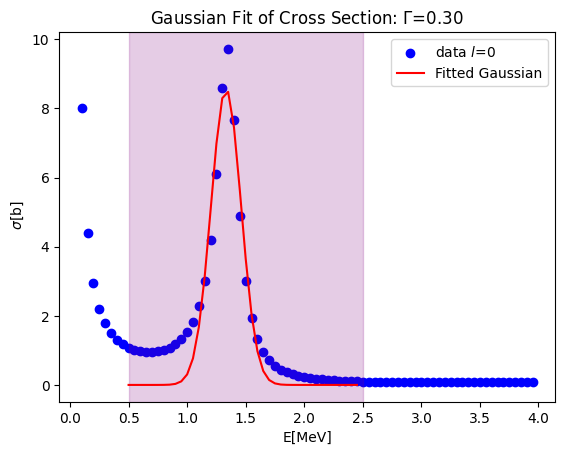

In [53]:
#Unit Conversion 
fm2barn = 0.01 # 1 barn = 100 fm2
# Cross section for Breit-Wigner Fit
# energy_range = np.arange(0.1,4.0,0.05)
cross_section=breit_wigner(L=2,delta=phase_shift,E=energy_range)*fm2barn


#Select the energy for which the fit looks better.
E_min = 0.5
E_max = 2.5

mask = (energy_range >= E_min) & (energy_range <= E_max)
energy_gated  = energy_range[mask]
cross_gated = cross_section[mask]

# Fit the data to the Gaussian function
popt, pcov = curve_fit(gaussian, energy_gated, cross_gated)
amplitude, mean, stddev = popt

def linear_fit(data: float,a: float,b: float):
    return a*data + b

#background fit (future tentative idea)
# E_bkgd = [1.8,2.7]

# mask_bkgd = (energy_range >= E_bkgd[0]) & (energy_range <= E_bkgd[1])
# energy_bkgd  = energy_range[mask_bkgd]
# cross_bkgd = cross_section[mask_bkgd]
# param, param_cov = curve_fit(linear_fit,energy_bkgd,cross_bkgd)

# plt.plot(energy_range, linear_fit(energy_range,*param),color='red',linestyle='dashed',label='Background Linear Fit')
plt.scatter(energy_range,cross_section,color = 'blue',label=rf'data, $l$={0}')
plt.axvspan(E_min,E_max,  alpha = 0.2, color = 'purple')
plt.plot(energy_gated, gaussian(energy_gated, *popt), color='red', label='Fitted Gaussian')

fwhm = 2.355 * stddev
print(f'standard dev: {stddev}')

plt.title(rf'Gaussian Fit of Cross Section: $\Gamma$={fwhm:0.2f}')




plt.xlabel('E[MeV]')
plt.ylabel(r' $\sigma$[b]')
plt.legend()
plt.show()


/tmp/ipykernel_239/1272292633.py:8: RuntimeWarning: overflow encountered in exp
  return V0/(1+np.exp((R-Rws)/aws))


NameError: name 'energy_gated' is not defined

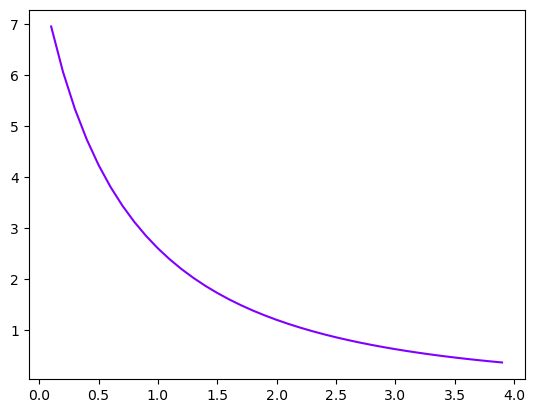

In [41]:
#Unit Conversion 
fm2barn = 0.01 # 1 barn = 100 fm2
# Cross section for Breit-Wigner Fit
color = iter(cm.rainbow(np.linspace(0,0.5,numbers_of_l+1)))
c = next(color)

total_cross_section = np.empty(len(cross_section))
for l in range(3):
    phase_shift = []
    for energy in energy_range:
        k = np.sqrt(0.0478450*energy)
        y_l0, yp_l0 = RKmethod(Rn=a,Lval=l,Eval=energy)
        y_l0_norm = normalize(y_l0)
        def function(R: float, A:float, B:float):
            """Fit the delta function"""
            return A*np.sin(k*R+ B - l*np.pi/2)
        #fit the sinudal expression for the Ul vs r plot.
        param, param_cov = curve_fit(function,r_array,y_l0_norm)
        phase_shift.append(param[1])

    cross_section=breit_wigner(L=l,delta=phase_shift,E=energy_range)*fm2barn
    plt.plot(energy_range,cross_section,color = c ,label=rf'data, $l$={l}')
    # plt.plot(energy_gated, gaussian(energy_gated, *popt), color='red', label='Fitted Gaussian')
    total_cross_section += cross_section
    # Fit the data to the Gaussian function
    popt, pcov = curve_fit(gaussian, energy_gated, cross_gated)
    amplitude, mean, stddev = popt
    print(f'l = {l} \t standard dev: {stddev}')
    c = next(color)

plt.plot(energy_range,total_cross_section,color = c ,label=rf'data, total')
# plt.axvspan(E_min,E_max,  alpha = 0.2, color = 'purple')
plt.title(rf'Gaussian Fit of Cross Section')
plt.xlabel('E[MeV]')
plt.ylabel(r' $\sigma$[b]')
plt.legend()
plt.show()

In [30]:
#Find the elastic cross-section
elastic_cross_section = []
energy_range = np.arange(0.1,4.0,0.1)
l_limit = 5
for idx,energy in enumerate(energy_range):
    cs = 0
    for l in range(0,l_limit+1):
        k = np.sqrt(0.0478450*energy)
        y_l0, yp_l0 = RKmethod(Rn=a,Lval=l,Eval=energy)
        y_l0_norm = normalize(y_l0)
        def function(R: float, A:float, B:float):
            """Fit the delta function"""
            return A*np.sin(k*R+ B - l*np.pi/2)
        #fit the sinudal expression for the Ul vs r plot.
        param, param_cov = curve_fit(function,r_array,y_l0_norm)
        cs += (4*np.pi/k**2)*(2*L + 1)*np.sin(param[1])**2
    elastic_cross_section.append(cs)     

/tmp/ipykernel_239/1272292633.py:8: RuntimeWarning: overflow encountered in exp
  return V0/(1+np.exp((R-Rws)/aws))


/tmp/ipykernel_239/1272292633.py:8: RuntimeWarning: overflow encountered in exp
  return V0/(1+np.exp((R-Rws)/aws))


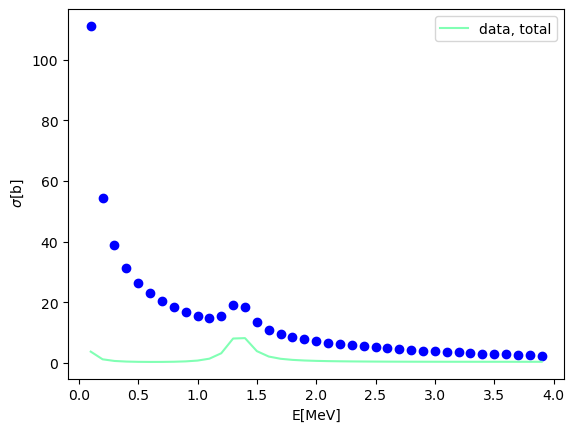

In [31]:
fm2barn = 0.01 # 1 barn = 100 fm2
elastic_cross_section = [ecs*fm2barn for ecs in elastic_cross_section]


/tmp/ipykernel_239/1272292633.py:8: RuntimeWarning: overflow encountered in exp
  return V0/(1+np.exp((R-Rws)/aws))


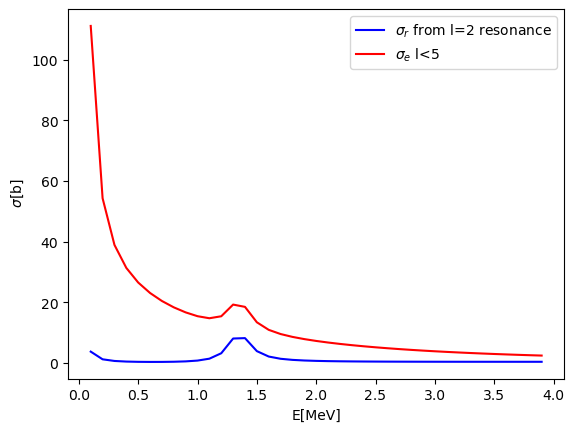

In [37]:
l=2
phase_shift = []
for energy in energy_range:
    k = np.sqrt(0.0478450*energy)
    y_l0, yp_l0 = RKmethod(Rn=a,Lval=l,Eval=energy)
    y_l0_norm = normalize(y_l0)
    def function(R: float, A:float, B:float):
        """Fit the delta function"""
        return A*np.sin(k*R+ B - l*np.pi/2)
    #fit the sinudal expression for the Ul vs r plot.
    param, param_cov = curve_fit(function,r_array,y_l0_norm)
    phase_shift.append(param[1])

cross_section=breit_wigner(L=l,delta=phase_shift,E=energy_range)*fm2barn
plt.plot(energy_range,cross_section,color = 'b' ,label=rf'$\sigma_r$ from l={2} resonance')
plt.plot(energy_range,elastic_cross_section,c='r',label = rf'$\sigma_e$ l<5')
plt.xlabel('E[MeV]')
plt.ylabel(r' $\sigma$[b]')
plt.legend()
plt.show()

In [38]:
plt.plot(energy_range,total_cross_section,color = 'b' ,label=rf'$\sigma_r$ from l={2} resonance')
plt.plot(energy_range,elastic_cross_section,c='r',label = rf'$\sigma_e$ l<5')
plt.xlabel('E[MeV]')
plt.ylabel(r' $\sigma$[b]')
plt.legend()
plt.show()

NameError: name 'total_cross_section' is not defined